In [1]:
import pandas as pd 
import numpy as np

In [2]:
import nltk
# nltk.download('all')# download nltk files
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from nltk.tokenize import sent_tokenize, word_tokenize 

In [3]:
import os 
import glob
import re
import time

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# %matplotlib inline


In [6]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchnlp.nn as nlp_nn
import pandas as pd
import numpy as np
import string
import json
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
torch.manual_seed(1)
# from tensorflow import summary
import random
from torch.autograd import Variable
# import tensorflow as tf

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [100]:
def ap(y_pred,y_belong):
  y_pred = np.array(y_pred)
  y_belong = np.array(y_belong)
  y_pred = y_pred.reshape(-1,1)
  y_belong = y_belong.reshape(-1,1)
  arr = np.concatenate((y_pred,y_belong),axis=1)
  
  arr = sorted(arr,key = lambda x:x[0],reverse=True)
  
  ans = 0
  rel = 0
  num = 0
  for i in range(len(y_pred)):
    if arr[i][1] == 1:
      rel = rel+1
      ans += rel/(i+1)
      num = num+1
  return ans/num

In [8]:
class MyModel(nn.Module):
    def __init__(self, embedding_dim, vocab_size, class_numbers):
        super(MyModel, self).__init__()
        self.H = 1
        self.K = class_numbers
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.H)
        self.fc = nn.Linear(self.H,1)
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out,_ = self.lstm(embeds.view(len(sentence),1,-1))
        return lstm_out

        
    def init_hidden(self,batch_size):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(1, batch_size, self.hidden_dim).zero_().to(device),
             weights.new(1, batch_size, self.hidden_dim).zero_().to(device))
        return h

In [8]:
model1 = MyModel(32,100,4)

In [9]:
class LSTM_TE(nn.Module):
    def __init__(self, embedding_dim,hidden_dim, vocab_size, class_numbers):
        super(LSTM_TE, self).__init__()
        self.H = hidden_dim
        self.K = class_numbers
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.H)
        self.att = nn.Linear(self.H, self.K,bias = True)
        self.att_norm = nn.Softmax(dim = 0)
        self.act = nn.Sigmoid()
        self.fin_ = nn.Softmax(dim = 0)
        self.fcs = [ nn.Linear(self.H,1) for _ in range(self.K)]
        self.c_prob = [ nn.Sigmoid() for _ in range(self.K)]
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out = lstm_out.view(len(sentence),self.H)
        att_denorm = self.att(lstm_out.view(len(sentence), -1)) # a_t = W_att * h_t + b_att
        att_denorm = self.act(att_denorm)       # a_t = sigmoid(a_t)
        As = self.att_norm(att_denorm) # A = softmax_row({a_1,..,a_d}^T)
        As = As.view(len(sentence),self.K) # A = D*K
        T = torch.zeros((self.H,self.K))
        for i in range(self.H):
          T[i] = torch.mul(torch.transpose(As,0,1),torch.transpose(lstm_out,0,1)[i]).sum(dim=1)
        # tag_scores  = torch.mul(As,lstm_out) # produce T = {T1,..,TK} 
        # tag_scores = self.fin_(tag_scores.sum(dim = 0)) 
        T = torch.transpose(T,0,1)

        rt = torch.zeros((self.K,1)).to(device)
        for i in range(self.K):
          rt[i] = self.fcs[i](T[i])
          rt[i] = self.c_prob[i](rt[i])
        return  rt
    def init_hidden(self,batch_size):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(1, batch_size, self.hidden_dim).zero_().to(device),
             weights.new(1, batch_size, self.hidden_dim).zero_().to(device))
        return h

In [10]:
def rem_stop(txt):
  return [ c for c in txt if c not in stopwords.words("english")]
stemmer = PorterStemmer()
def word_stemm(txt):
  return [stemmer.stem(w) for w in txt]

In [11]:
xl_files_train = glob.glob("./dataset/Task1/Train/*.xlsx")
xl_files_test = glob.glob("./dataset/Task1/Test/*.xlsx")

In [12]:
xl_files_test

['./dataset/Task1/Test/Loss.xlsx',
 './dataset/Task1/Test/Frustrative_Nonreward.xlsx',
 './dataset/Task1/Test/Sleep_Wakefulness.xlsx',
 './dataset/Task1/Test/Sustained_Threat.xlsx',
 './dataset/Task1/Test/Potential_Threat_Anxiety.xlsx',
 './dataset/Task1/Test/Circadian_Rhythms.xlsx',
 './dataset/Task1/Test/Arousal.xlsx',
 './dataset/Task1/Test/Acute_Threat_Fear.xlsx']

In [13]:
# create labels
labels = {}
revLabels = {}
for i,xl in  enumerate(xl_files_train):
    className = xl.split("/")[-1][:-5]
    labels[className] = i
    revLabels[i] = className

In [14]:
#train dataframes
frames = []
for xl_file in xl_files_train:
    df1 = pd.read_excel(xl_file)
    className = xl_file.split("/")[-1][:-5]
    df1['Y'] = labels[className]
    frames.append(df1)
df_train = pd.concat(frames,ignore_index = True)

In [15]:
#test dataframes
frames = []
for xl_file in xl_files_test:
    df1 = pd.read_excel(xl_file)
    className = xl_file.split("/")[-1][:-5]
    df1['Y'] = labels[className]
    frames.append(df1)
df_test = pd.concat(frames,ignore_index = True)

In [34]:
PUNC_LIST = string.punctuation + string.digits
TOKENIZER = re.compile(r"\w+")
def clean_text(text):
    """
        Removes non-alphabetic characters
    """
    #remove new line and carriage with space
    text = text.replace("\n"," ").replace("\r"," ")
    tmp = str.maketrans(dict.fromkeys(PUNC_LIST," "))
    text = text.translate(tmp)
    # replace single quote with empty 
    tmp  = str.maketrans(dict.fromkeys("'`",""))
    return text.translate(tmp)
def regexTokenize(text):

    return TOKENIZER.findall(clean_text(text)

In [36]:
# pre process the text
stop_words = stopwords.words("english")
cols = ['title','abstract']
for col in cols :
    df_train['c_'+col] = df_train[col].apply(lambda x: " ".join([stemmer.stem(i) for i in regexTokenize(x) if i not in stop_words]))
    df_test['c_'+col] = df_test[col].apply(lambda x: " ".join([stemmer.stem(i) for i in regexTokenize(x) if i not in stop_words]))

In [17]:
def toTensor(inp):
  return torch.tensor(inp,dtype = torch.long)

In [50]:
# concatenate the entire text
df_train['inp'] =  df_train['c_title'] + df_train['c_abstract']
c_title = df_train[['c_title','pmid']].values

In [22]:
VOCAB_SIZE = len(vectorizer.vocabulary_.keys()) + 1
CLASS_SIZE = 8
EMBED_DIM = 1
HIDDEN_DIM = 1

In [39]:
x_train = df_train['inp'].values

In [40]:
xs = df_train['inp'].values

In [75]:
tfidf = TfidfVectorizer(lowercase=False)#, tokenizer=regexTokenize)

In [91]:
df_test.columns 

Index(['pmid', 'title', 'abstract', 'Belongs to RDoC construct?',
       'Relevant Context', 'Y', 'c_title', 'c_abstract'],
      dtype='object')

In [53]:
# frequency analysis
voc = {}
for row in xs:
    for w in row.split():
        if w in voc : 
            voc[w] += 1
        else:
            voc[w] = 1

In [67]:
freqList = []
v= 1000
label = []
for k in voc.keys():
        freqList.append(voc[k])
        label.append(k)
        if voc[k] > 400:
            print(k,voc[k])

sleep 513


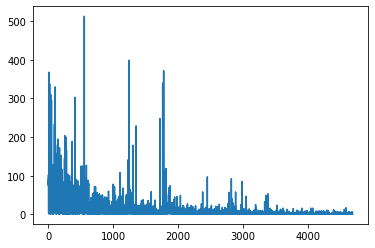

In [58]:
plt.plot(freqList)

In [76]:
# %matplotlib ipympl
xs_t = tfidf.fit_transform(xs).toarray()

In [77]:
# print(counter.get_feature_names())
ys = list(map(len,xs_t))

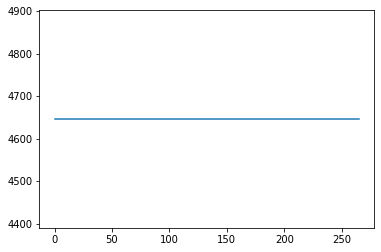

In [78]:
plt.plot(ys)

In [85]:
y_train = df_train['Y'].values
x_train = xs_t

In [119]:
# USING RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth =50,oob_score = True,criterion="entropy",n_jobs=-1)


In [120]:
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [36]:
# Y_train = df_train['Y'].apply(toTensor).values

In [35]:
model = LSTM_TE(EMBED_DIM, HIDDEN_DIM, VOCAB_SIZE, CLASS_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001)

In [37]:
for epoch in range(5):
    epoch_loss = 0
    st_time = time.time() 
    for i in range(len(x_trainx)):
        model.zero_grad()
        loss = loss_function( model( x_trainx[i] ).reshape((1,8)) , Y_train[i].reshape((1)) )
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print( time.time() - st_time )

358.9650790691376
354.49069690704346
353.1128478050232
352.3536539077759
653.7088289260864


In [40]:
df_test.columns = ['pmid', 'title', 'abstract', 'Belongs','Relevant Context', 'Y', 'c_title', 'c_abstract']

In [80]:
df_test['inp'] = df_test['c_title']  + df_test['c_abstract']

In [85]:
x_test = df_test['inp'].values

In [86]:
x_test = list(vectorizer.transform( x_test ).toarray())

In [88]:
x_test[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [89]:
df_test['inp2'] = x_test

In [104]:
df_test['inp'] = df_test['c_title'] + df_test['c_abstract']
df_test['Belongs'] = df_test['Belongs to RDoC construct?']
gdf = df_test.groupby('Y')

In [105]:
# gdf.groups
construct_test = {}
for i in range(8):
  construct_test[i]= df_test.iloc[gdf.groups[i]]

In [117]:
map_list = []
class_count = {}
for _ in range(10):
  aps = 0
  for cl_ in construct_test.keys():
    X_test = tfidf.transform(construct_test[cl_]['inp']).toarray()
    y_pred = rfc.predict_proba(X_test)[:,cl_]
    # print(y_pred.shape)
    y_belongs = np.array(construct_test[cl_]['Belongs'].values).reshape(len(X_test),1)
    # print(y_belongs.shape)
    # print(np.concatenate((y_belongs,y_pred),axis =1 ))
    t = ap(y_pred,y_belongs)
    print(revLabels[cl_],t)
    aps += t
  # println()
  map_list.append(aps/8)
  # break


Loss 0.6044427301983917
Frustrative_Nonreward 0.659893358313573
Sleep_Wakefulness 0.998197909388957
Sustained_Threat 0.5988373139249042
Potential_Threat_Anxiety 0.964303629453986
Circadian_Rhythms 1.0
Arousal 0.9362103088721436
Acute_Threat_Fear 0.7729992238122487
Loss 0.6044427301983917
Frustrative_Nonreward 0.659893358313573
Sleep_Wakefulness 0.998197909388957
Sustained_Threat 0.5988373139249042
Potential_Threat_Anxiety 0.964303629453986
Circadian_Rhythms 1.0
Arousal 0.9362103088721436
Acute_Threat_Fear 0.7729992238122487
Loss 0.6044427301983917
Frustrative_Nonreward 0.659893358313573
Sleep_Wakefulness 0.998197909388957
Sustained_Threat 0.5988373139249042
Potential_Threat_Anxiety 0.964303629453986
Circadian_Rhythms 1.0
Arousal 0.9362103088721436
Acute_Threat_Fear 0.7729992238122487
Loss 0.6044427301983917
Frustrative_Nonreward 0.659893358313573
Sleep_Wakefulness 0.998197909388957
Sustained_Threat 0.5988373139249042
Potential_Threat_Anxiety 0.964303629453986
Circadian_Rhythms 1.0
Arou

In [118]:
np.mean(map_list)

0.8168605592455256

In [98]:
map_list = []
class_count = {}
for _ in range(1):
  aps = 0
  for cl_ in construct_test.keys():
    X_test = construct_test[cl_]['inp2'].apply(toTensor).values
    y_pred = torch.randn((len(X_test),1)).to(device)
    class_count[cl_] = len(X_test)
    for i in range(len(X_test)):
      y_pred[i] = model(X_test[i].to(device))[cl_,0].reshape(1,1)
    y_pred = y_pred.cpu().detach().numpy()
    # print(y_pred.shape)
    y_belongs = np.array(construct_test[cl_]['Belongs'].values).reshape(len(X_test),1)
    # print(y_belongs.shape)
    # print(np.concatenate((y_belongs,y_pred),axis =1 ))
    t = ap(y_pred,y_belongs)
    print(labels[cl_],t)
    aps += t
  # println()
  map_list.append(aps/8)
  # break


KeyError: 0

In [ ]:
def ap(y_pred,y_belong):
  y_pred = np.array(y_pred)
  y_belong = np.array(y_belong)
  y_pred = y_pred.reshape(-1,1)
  y_belong = y_belong.reshape(-1,1)
  arr = np.concatenate((y_pred,y_belong),axis=1)
  
  arr = sorted(arr,key = lambda x:x[0],reverse=True)
  
  ans = 0
  rel = 0
  num = 0
  for i in range(len(y_pred)):
    if arr[i][1] == 1:
      rel = rel+1
      ans += rel/(i+1)
      num = num+1
  return ans/num

def map(y_pred,y,y_belong):
  j = 0
  j_prev = 0
  ans = 0
  for i in range(8):
    while j<len(y) and y[j] == i:
      j = j+1
    ans = ans + ap(y_pred[j_prev:j],y_belong[j_prev:j])
    j_prev = j
  return ans/8
